In [1]:
import math as m
import h5py 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = h5py.File("Stshp_Proton_3.98_38.2_180.0_3.hdf5", "r")
ds = [n for n in f.keys()]
#proj_info = dict(ds['RunInfo'].attrs.items())
print(ds)

['RunInfo', 'RunInfo.__table_column_meta__', 'Stshp_Proton_3.98_38.2_180.0_3']


In [3]:
def print_h5_structure(f, level=0):
    """    prints structure of hdf5 file    """
    for key in f.keys():
        if isinstance(f[key], h5py._hl.dataset.Dataset):
            print(f"{'  '*level} DATASET: {f[key].name}")
        elif isinstance(f[key], h5py._hl.group.Group):
            print(f"{'  '*level} GROUP: {key, f[key].name}")
            level += 1
            print_h5_structure(f[key], level)
            level -= 1

        if f[key].parent.name == "/":
            print("\n"*2)


file_path = "Stshp_Proton_3.98_38.2_180.0_3.hdf5"
f = h5py.File(file_path, 'r')

#print_h5_structure(f)

In [4]:

class Antenna:
    """ antenna with location and timeseries of Efield"""
    def __init__(self,x,y,z,name=""):
        self.x = x
        self.y = y
        self.z = z
        self.name = name

class REvent:
    """ An interface class for reading simulations """
    def __init__(self,filename):
        self.reasfile = filename
        if '.reas' in filename:
            self.reasfile = filename
            self.parse_reas()
        elif '.hdf5' in filename:
            self.hdf5file = filename
            self.parse_hdf5()

    def parse_reas(self):
        """ parse *reas file """
        f = open(self.reasfile)
        lines = f.readlines()
        for l in lines:
            if 'ShowerZenithAngle' in l:
                self.zenith = float(l.split()[2])
            if 'ShowerAzimuthAngle' in l:
                self.azimuth = float(l.split()[2]) + 180
                if self.azimuth > 360:
                    self.azimuth = self.azimuth - 360
            if 'DepthOfShowerMaximum' in l:
                self.Xmax = float(l.split()[2])
            if 'PrimaryParticleEnergy' in l:
                self.energy = float(l.split()[2])
            if 'PrimaryParticleType' in l:
                self.part_id = int(l.split()[2])
            if 'MagneticFieldInclinationAngle' in l:
                self.Binc = float(l.split()[2])
            if 'MagneticFieldStrength' in l:
                self.Bmag = float(l.split()[2])
        self.parse_reas_antenas()

    def parse_reas_antenas(self):
        """Parse the antennas by reas """
        self.listfile = self.reasfile.replace('.reas','.list')
        f = open(self.listfile)
        lines = f.readlines()
        self.antennas = []
        for l in lines:
            a = Antenna(float(l.split()[2]),float(l.split()[3]),float(l.split()[4]),l.split()[5])
            efile = self.listfile.replace('.list','_coreas/raw_'+ a.name + '.dat')
            a.t, a.Ex, a.Ey, a.Ez = np.loadtxt(efile,unpack=True)
            self.antennas.append(a)

    def parse_hdf5(self):
        f = h5py.File(self.hdf5file, "r")
        self.antennas = []
        ai = f[list(f.keys())[-1] + '/AntennaInfo']
        for ai_ in ai:
            a = Antenna(ai_[1],ai_[2],ai_[3],ai_[0].decode('UTF-8'))
            self.antennas.append(a)
        print('read ' +  str(len(self.antennas)) + ' antennas')

        traces = f[list(f.keys())[-1] + '/AntennaTraces']
        for tr in traces:
            for a in self.antennas:
                if a.name == tr:
                    break
            a.t = []
            a.Ex = []
            a.Ey = []
            a.Ez =[]
            for tup in traces[tr + '/efield']:
                a.t.append(tup[0])
                a.Ex.append(tup[1])
                a.Ey.append(tup[2])
                a.Ez.append(tup[3])

        ei = f[list(f.keys())[-1] + '/EventInfo']
        ei=ei[0]
        self.zenith = 180.-ei[4]
        self.azimuth = ei[5]
        self.xmax = ei[9]
        self.energy = ei[3]
        self.part_id = ei[2].decode('UTF-8')
        self.Bmag = ei[16]
        self.Binc = ei[17]
        self.Bdec = ei[18]
        self.ground=ei[11]
        self.dist_xmax=ei[6]



In [5]:
f = h5py.File('Stshp_Proton_3.98_38.2_180.0_3.hdf5', "r")
antennas = []
ai = f[list(f.keys())[-1] + '/AntennaInfo']
for ai_ in ai:
    a = Antenna(ai_[1],ai_[2],ai_[3],ai_[0].decode('UTF-8'))
    antennas.append(a)
print('read ' +  str(len(antennas)) + 'antennas')
traces = f[list(f.keys())[-1] + '/AntennaTraces']
for tr in traces:
    for a in antennas:
        if a.name == tr:
            break
    a.t = []
    a.Ex = []
    a.Ey = []
    a.Ez =[]
    for tup in traces[tr + '/efield']:
        a.t.append(tup[0])
        a.Ex.append(tup[1])
        a.Ey.append(tup[2])
        a.Ez.append(tup[3])

ei = f[list(f.keys())[-1] + '/EventInfo']
ei=ei[0]
zenith = 180.-ei[4]
azimuth = ei[5]
xmax = ei[9]
energy = ei[3]
part_id = ei[2].decode('UTF-8')
Bmag = ei[16]
Binc = ei[17]
Bdec = ei[18]
ground=ei[11]
dist_xmax=ei[6]

read 176antennas


read 176 antennas


/tmp/ipykernel_14226/2310408955.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_14226/2310408955.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


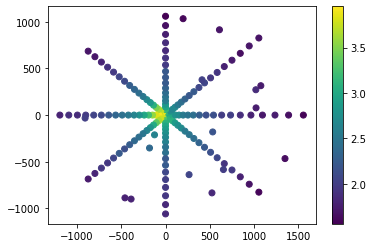

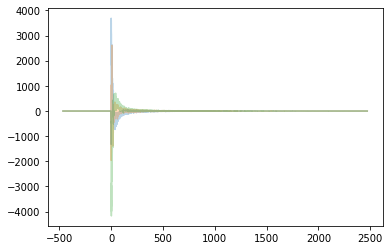

In [6]:
######################################################
file='Stshp_Proton_3.98_38.2_180.0_3.hdf5'

ev = REvent(file)
x = np.asanyarray([a.x for a in ev.antennas])
y = np.asanyarray([a.y for a in ev.antennas])
maxVals = [np.max([np.max(a.Ex),np.max(a.Ey),np.max(a.Ez)])for a in ev.antennas]
lmaxVals=np.asanyarray( np.log10(maxVals))
cut = lmaxVals>-8

fig = plt.figure()
plt.scatter(x[cut],y[cut],c=lmaxVals[cut])
plt.colorbar()
fig.show()

fig = plt.figure()
plt.plot(ev.antennas[0].t,ev.antennas[0].Ex,alpha=0.3)
plt.plot(ev.antennas[0].t,ev.antennas[0].Ey,alpha=0.3)
plt.plot(ev.antennas[0].t,ev.antennas[0].Ez,alpha=0.3)
fig.show()


(-1500.0, 2500.0)

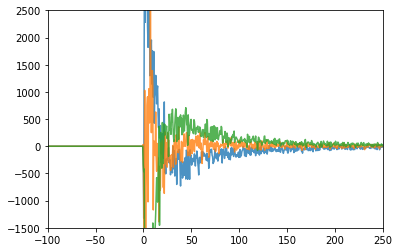

In [7]:
fig = plt.figure()
plt.plot(ev.antennas[0].t,ev.antennas[0].Ex,alpha=0.8)
plt.plot(ev.antennas[0].t,ev.antennas[0].Ey,alpha=0.8)
plt.plot(ev.antennas[0].t,ev.antennas[0].Ez,alpha=0.8)
plt.xlim(-100,250)
plt.ylim(-1500, 2500)

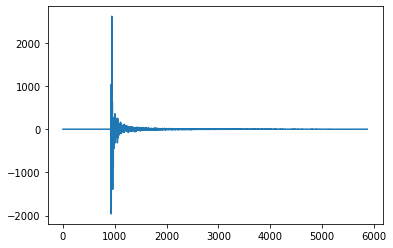

In [8]:
plt.plot(ev.antennas[0].Ey)

In [9]:
import h5py
filename = "Stshp_Proton_3.98_38.2_180.0_3.hdf5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])

Keys: <KeysViewHDF5 ['RunInfo', 'RunInfo.__table_column_meta__', 'Stshp_Proton_3.98_38.2_180.0_3']>


In [10]:
display(data)

[(b'Stshp_Proton_3.98_38.2_180.0_3', b'N/A', b'Proton', 3.9811, 141.77, 0., 3190., 843.91, b' SIBYLL23c\n', 100000.)]

In [11]:
count=0
for i in range(len(ev.antennas[0].Ey)):
    count+=1
print (count)

5874


In [12]:
from scipy import stats
time=np.array(ev.antennas[0].t)
diff=[]
i=1
while i < int(len(time)+1):
    diff2=time[i+1]-time[i]
    np.append(diff,diff2)
    if i == int(len(time)-2):
        break
    i += 1 
print(stats.mode(diff2)) #calculating the average time between time intervals in  nano seconds

ModeResult(mode=array([0.5], dtype=float32), count=array([1]))


In [13]:
from scipy import stats
time=np.array(ev.antennas[0].t)
diff=[]
i=1
while i < int(len(time)+1):
    diff2=time[i+1]-time[i]
    np.append(diff,diff2)
    if i == int(len(time)-2):
        break
    i += 1 
print(stats.describe(diff2)) #calculating the average time between time intervals in  nano seconds

DescribeResult(nobs=1, minmax=(0.5, 0.5), mean=0.5, variance=nan, skewness=0.0, kurtosis=-3.0)


/snap/root-framework/412/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/snap/root-framework/412/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


initialilizing a bandpass filter and checking if this commit holds)

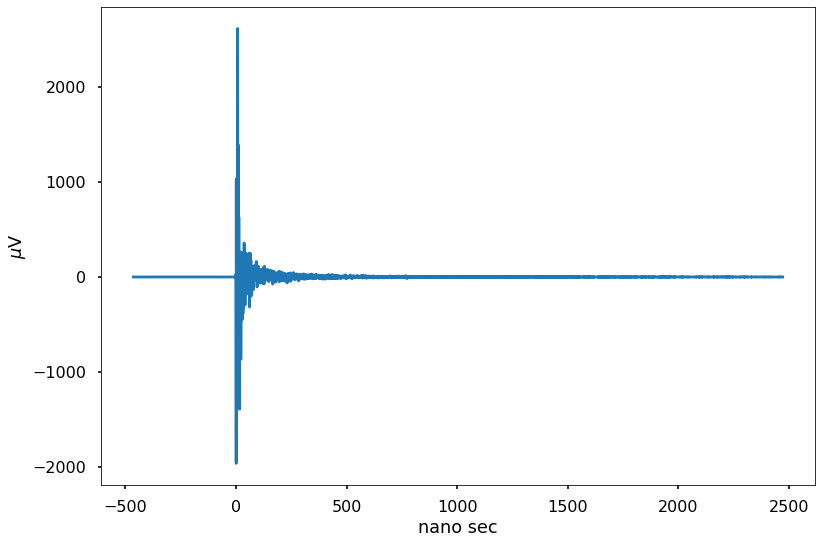

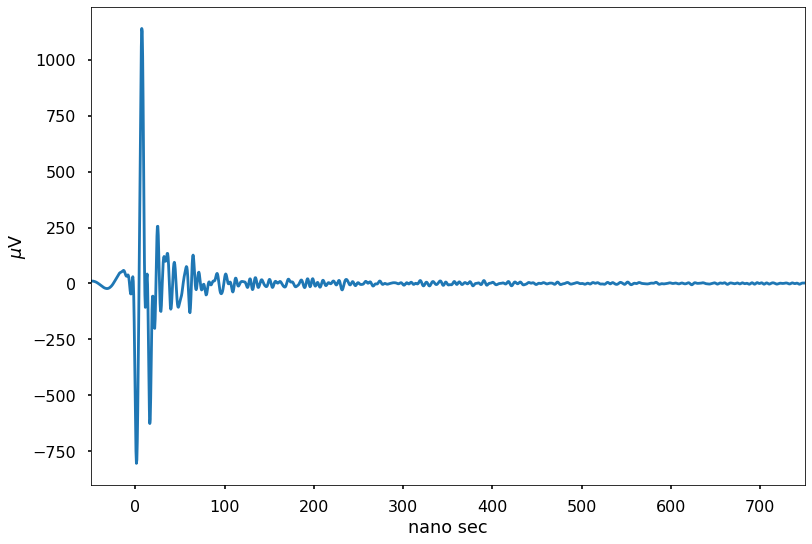

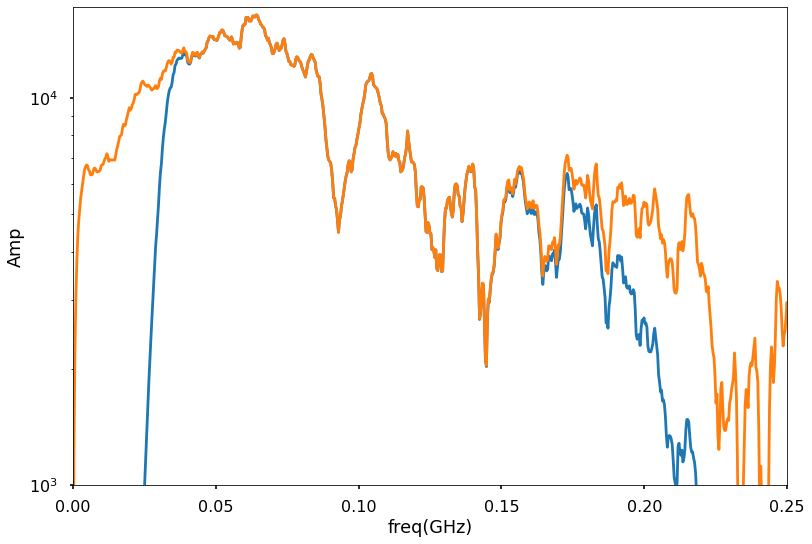

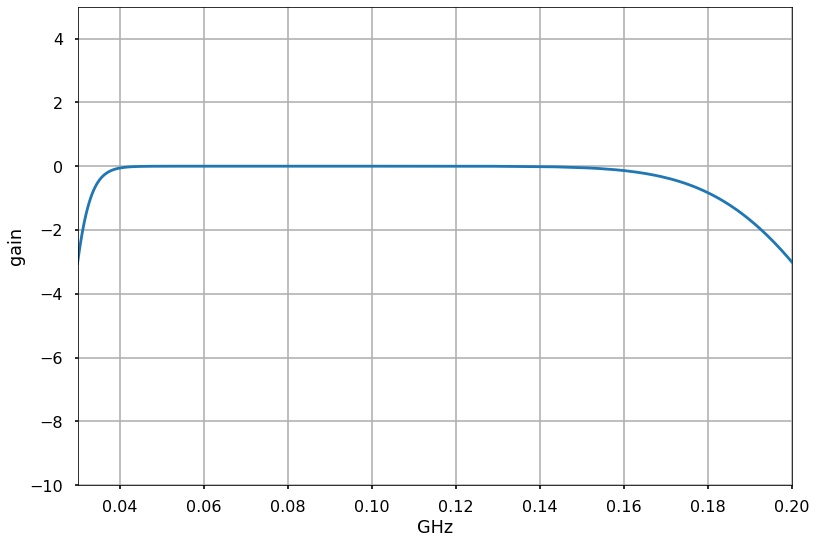

In [14]:
from scipy import signal
from scipy.signal import filtfilt
from scipy.fftpack import fft, ifft
import scipy
plt.style.use('seaborn-poster')



def plot():
    data=ev.antennas[0].Ey
    ev_data=np.array(data)
    time=ev.antennas[0].t
    dt= time[1]-time[0]
    plt.plot(time,ev_data)
    plt.xlabel('nano sec')  
    plt.ylabel('$\mu$V') 
    plt.show()
    filtered_signal=bandPassFilter(ev_data,1/dt)
    plt.plot(time,filtered_signal)
    plt.xlabel('nano sec')  
    plt.ylabel('$\mu$V') 
    plt.xlim(-50,750)
    plt.show()
    freq=np.linspace(0,1/dt,len(data))
    plt.plot(freq,abs(fft(filtered_signal)))
    plt.plot(freq,abs(fft(data)))
    plt.xlabel('freq(GHz)')  
    plt.ylabel('Amp') 
    plt.ylim(1000,)
    plt.yscale('log')
    plt.xlim(0,0.25)
    plt.show()
    plt.plot(freq,10*np.log10(abs(fft(filtered_signal))/abs(fft(data))))
    plt.xlabel('GHz')  
    plt.ylabel('gain') 
    plt.ylim(-10,5)
    plt.xlim(.03,0.2)
    plt.grid()
    plt.show()
    #print(np.where(round(freq) == 0.08))
    
def bandPassFilter(signal,fs,lowcut=0.03, hicut=0.20, order = 5):#GHz
    niq=fs/2
    low= lowcut/niq
    high=hicut/niq
   
    b,a=scipy.signal.butter(order,[low,high],'bandpass',analog=False)
    y = scipy.signal.filtfilt(b,a,signal)
    
    return (y)
plot()

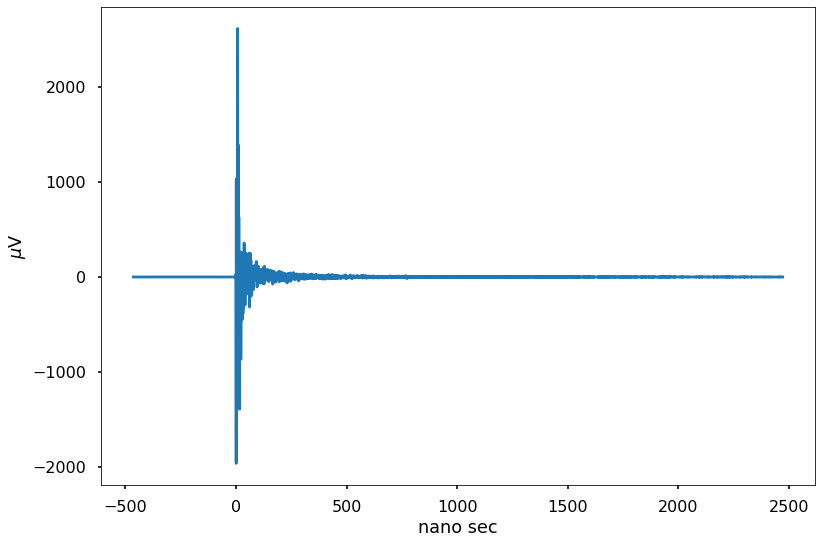

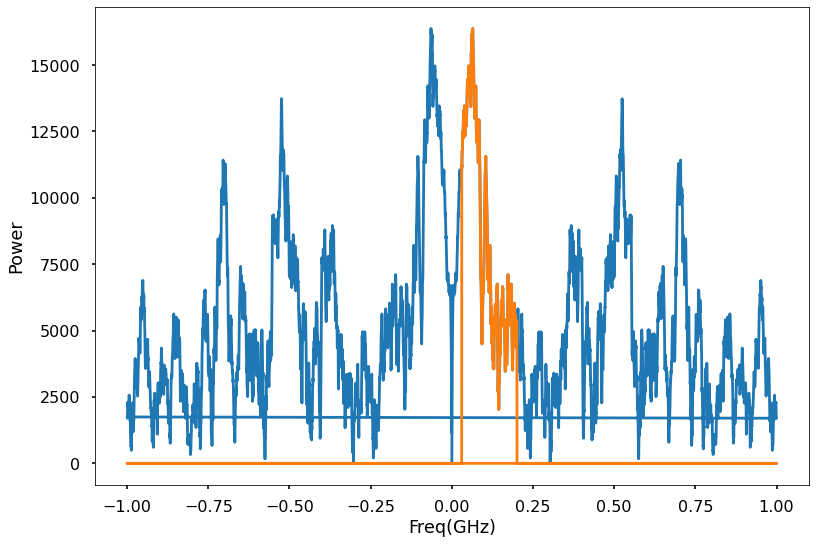

/snap/root-framework/412/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


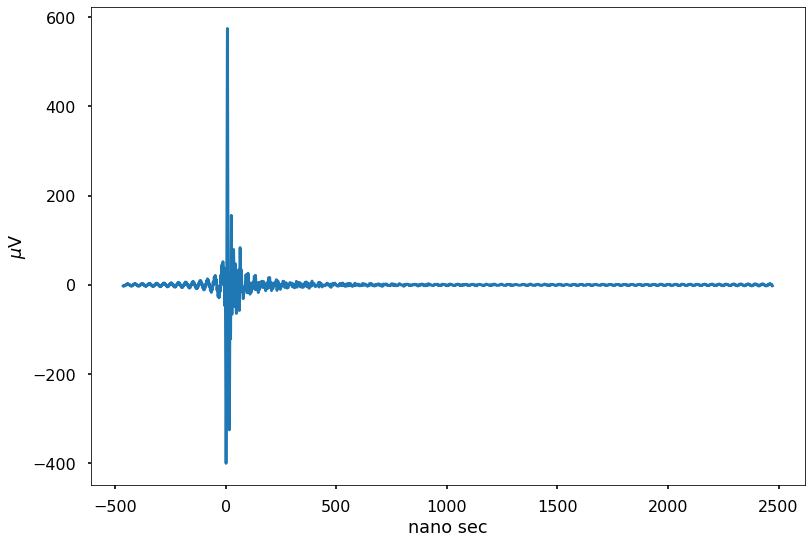

In [15]:
def squarband():
    data=np.array(ev.antennas[0].Ey)
    N=data.size
    time=ev.antennas[0].t
    dt= time[1]-time[0]# interval between steps
    T = 1.0/dt
    yf=np.fft.fft(data)
    xf =np.fft.fftfreq(N, 1/T)#[:round(N/2+1)]

    x_rel_plot2=[]
    for index in range(len(xf)):
        if 0.03<xf[index-1]<0.2:
            x_rel_plot2=np.append(x_rel_plot2,yf[index])      
        else:
            x_rel_plot2=np.append(x_rel_plot2,0)
    index+=1

    y_recon2=np.fft.ifft(x_rel_plot2)
 
    plt.style.use('seaborn-poster')

    plt.plot(time,data,'-')
    plt.xlabel('nano sec')  
    plt.ylabel('$\mu$V') 
    plt.show()
    plt.plot(xf,abs(yf))
    plt.ylabel('Power')  
    plt.xlabel('Freq(GHz)')
    #plt.plot(xf,yf,'-')
    #plt.show()
    plt.plot(xf,abs(x_rel_plot2),'-')
    plt.ylabel('Power')  
    plt.xlabel('Freq(GHz)') 
    #plt.xlim(0,0.1)
    plt.show()
    plt.plot(time,y_recon2,'-')
    plt.xlabel('nano sec')  
    plt.ylabel('$\mu$V') 
    
squarband()